# Experiments expanding on Ito et al. (2017)


In [1]:
import copy
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm

## Import custom modules
# Primary module with most model functions
import model
# Module for FC regression
import multregressionconnectivity as mreg

## Experiment 1: GLM recovery of simulated task activity


### Create network

One hub and two local networks

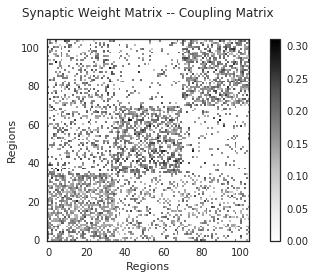

In [2]:
#### Set up subject network matrix ####
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

#### Simulate resting state activity using information flow model

Apply neural networl model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point

**Note that this is still in synaptic space (i.e. not convolved)**

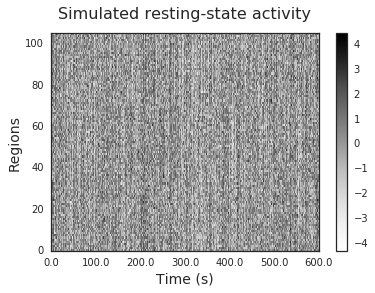

In [3]:
## Set up simulation parameters
Tmaxrest = 60000
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0
TRLength = 100

restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)

plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmaxrest+1,10000),np.arange(0,Tmaxrest+1,10000)/100)
plt.colorbar()

#### Convolve resting state activity

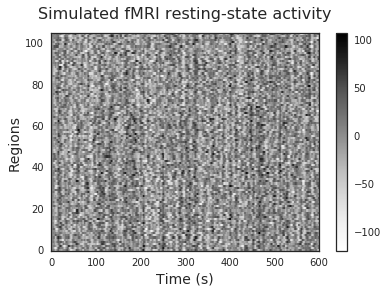

In [4]:
restfmri = model.convolveTimeseries(restdata,
                                    samplingrate=dt,
                                    TRLength=TRLength)
plt.figure()
plt.imshow(restfmri, aspect='auto',origin='lower')
plt.title('Simulated fMRI resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

#### Recover connectivity matrix from resting state activity

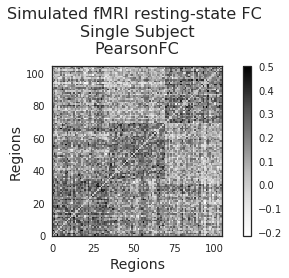

In [5]:
fcmat = np.corrcoef(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat,0)

plt.figure()
plt.imshow(fcmat, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC \nSingle Subject\nPearsonFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

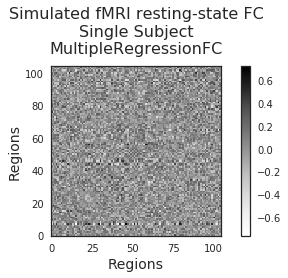

In [6]:
fcmat_mreg = mreg.multregressionconnectivity(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat_mreg,0)

plt.figure()
plt.imshow(fcmat_mreg, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC\nSingle Subject\nMultipleRegressionFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

### Simulate task activity using resting state

- Decide on the stimulus on/off for the I matrix
- How do you decide the task's spatial specificity, i.e. which network and nodes within a network it affects primarily? 
    - In the simulations the approach is: For topdown tasks only the hub network is simulated. E.g. for task 1 the first quarter of nodes are stimulated, for task 2 the next quarter etc. 
    - For topdown and bottom up (where a bug was fixed) it is a bit more complicated. E.g. for task 5 the first quarter of the hub network and the nodes of network 1 (first local network) that connect to the hub network (network 0) are stimulated
- Use model.networkmodel with G weights matrix and I task matrix

#### Hub network stimulation

In [7]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 10000

T = np.arange(0,Tmax,dt)

taskdata = {}
stimtimes = {}
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

In [8]:
topdown_only = range(1,5)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

for t in range(len(T)):
    if tasktiming[0,t] == 1:
        # Task stimulation every 10 seconds for 4 seconds, excluding the first 10 seconds
        stimtimes[task][stim_nodes,t] = .5

Block design task looks like:

(-0.1, 1.2)

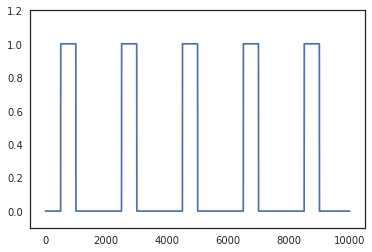

In [9]:
plt.plot(T, tasktiming[0])
plt.ylim(top = 1.2, bottom = -0.1)

Activated nodes in the hub network *only* (making it a top-down task) are:

In [10]:
stim_nodes

array([0, 1, 2, 3, 4, 5, 6, 7])

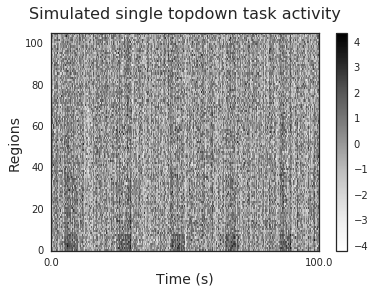

In [11]:
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

plt.figure()
plt.imshow(taskdata[task], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

##### Convolve task activity 


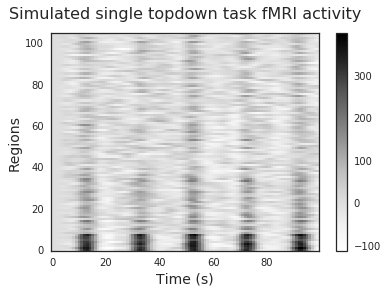

In [12]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
task_bold = model.convolveTimeseries(taskdata[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)
plt.figure()
plt.imshow(task_bold, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

##### Run GLM on convolved task activity

In [13]:
n_skip_BOLD = int(TRLength)
# Temporally downsample task timing to seconds (before convolving)
timingconv = tasktiming[:,::n_skip_BOLD]
timingconv.shape = (timingconv.shape[1],)
hrfsample_rate=1.0 # HRF is sampled at seconds
hrfsample_times = np.arange(0, 30, hrfsample_rate, dtype=float)
hrf_at_simsample = model.hrf(hrfsample_times)
hrfconvtime = np.convolve(timingconv, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = hrfconvtime[:-n_to_remove]
# Output
timing_convolved_downsampled = convolved

In [14]:
task_betas_postfmri, task_resids_postfmri, task_tvals_postfmri, task_betas_ci_postfmri = model.runTaskGLM(task_bold, timing_convolved_downsampled)

Results of GLM. Vertical lines indicate network boundaries. Stimulated nodes are the first eight in the hub network.

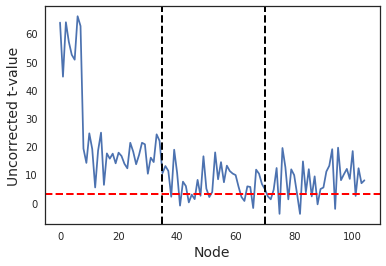

In [15]:
plt.plot(task_tvals_postfmri)
plt.ylabel('Uncorrected t-value',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=3,linewidth=2, color='red', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")

Text(0.5, 0, 'Node')

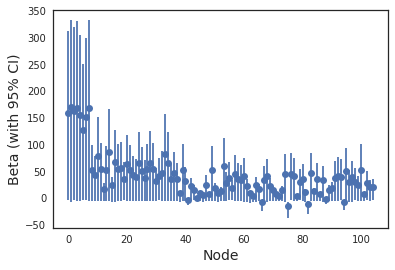

In [16]:
uperror = task_betas_ci_postfmri[:,1]
downerror = task_betas_ci_postfmri[:,0]
errorbars = np.concatenate(([uperror], [downerror]), axis=0)

plt.errorbar(np.arange(totalnodes), task_betas_postfmri, yerr=errorbars, fmt = 'o')
plt.ylabel('Beta (with 95% CI)',fontsize=14)
plt.xlabel('Node',fontsize=14)

In [17]:
hub_stim_nodes = stim_nodes

#### Local network stimulation

In [18]:
topdown_and_bottomup = range(5,9)
task = 5

# Identify task number for this type of stimulation
taskcount = task-np.min(topdown_and_bottomup) # Starts @ 0; iterates for len(flexandlocalnets)
# Find stimulation nodes for the hub network
networkstim = taskcount # since number of stimuli depend on number of tasks
# Split half the stim size for each network for an equal number of stimulated nodes across networks
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((networkstim)*stimsize,(networkstim)*stimsize+stimsize,dtype=int)

# Find stimulation nodes of local communities
# This starts @ 1 for task 1. Then iterates to community 2-4 for each subsequent task
community = taskcount + 1  
local_ind = np.where(Ci==community)[0] # Identify indices for the local community associated for this task (bottom-up stimulation regions)
# Identify efferent connections from local network to hub network
W_mask = np.zeros((W.shape))
W_mask[local_ind,hub_ind] = 1.0
local2hub_connects = np.multiply(W,W_mask)
local_regions = np.where(local2hub_connects==1)[0]  # only look for local regions that innervate hub regions

# Identify regions in the hub network and this local network that have connections
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes2 = local_regions[0:int(stimsize)] 

# Stack hub nodes with local network nodes
stim_nodes = np.hstack((stim_nodes,stim_nodes2))
stimtimes[task] = np.zeros((totalnodes,len(T)))

In [19]:
stim_nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7, 37, 40, 42, 45, 55, 57, 64, 65])

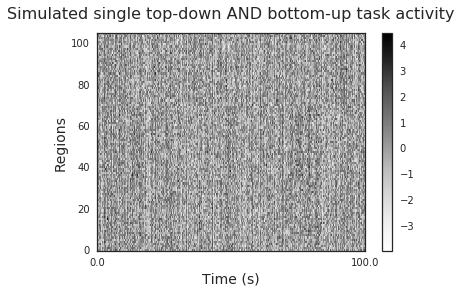

In [20]:
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

plt.figure()
plt.imshow(taskdata[task], aspect='auto',origin='lower')
plt.title('Simulated single top-down AND bottom-up task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

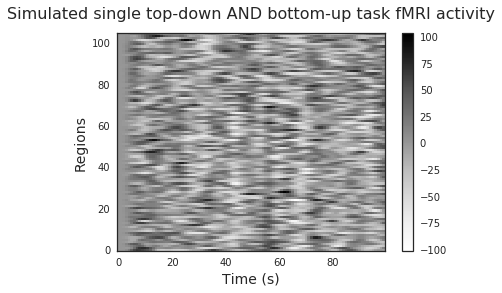

In [21]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
local_task_bold = model.convolveTimeseries(taskdata[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)
plt.figure()
plt.imshow(local_task_bold, aspect='auto',origin='lower')
plt.title('Simulated single top-down AND bottom-up task fMRI activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

In [22]:
local_task_betas_postfmri, local_task_resids_postfmri, local_task_tvals_postfmri, local_task_betas_ci_postfmri = model.runTaskGLM(local_task_bold, timing_convolved_downsampled)

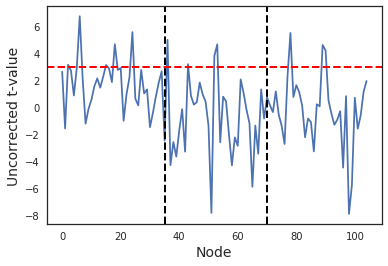

In [23]:
plt.plot(local_task_tvals_postfmri)
plt.ylabel('Uncorrected t-value',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=3,linewidth=2, color='red', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")

In [24]:
local_stim_nodes = stim_nodes

### Relationship between betas and weights from the connectivity matrix

Extract average connectivity between each node and the nodes stimulated by task.  
Correlate these average weights with betas for each node.

NOTE: The weight matrix is *NOT* symmetric (I think) because afferent and efferent connection weights need not be the same.

In [25]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(G)

False

Extract average connectivity of each node with the stim nodes

In [26]:
afferent_cons = np.empty((0,G.shape[0]), float)
efferent_cons = np.empty((0,G.shape[0]), float)
for i in range(G.shape[0]):
    efferent_cons = np.append(efferent_cons, [G[hub_stim_nodes,i].mean()])
    afferent_cons = np.append(afferent_cons, [G[i,hub_stim_nodes].mean()])

Text(0.5, 1.0, 'Correlation between betas and efferent connections')

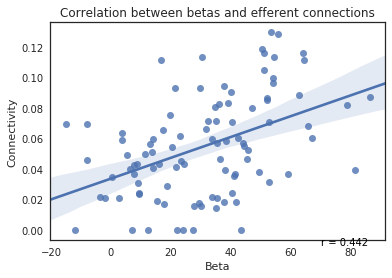

In [27]:
d = {'Beta': task_betas_postfmri[8:], 'Connectivity': efferent_cons[8:]}
df = pd.DataFrame(data=d)
p = sns.regplot(x='Beta', y='Connectivity', data = df)
p.text(70, -0.01, "r = %s"%(str(round(np.corrcoef(task_betas_postfmri[8:], efferent_cons[8:])[1][0],3))), horizontalalignment='left', color='black')
p.set_title('Correlation between betas and efferent connections')

Text(0.5, 1.0, 'Correlation between betas and afferent connections')

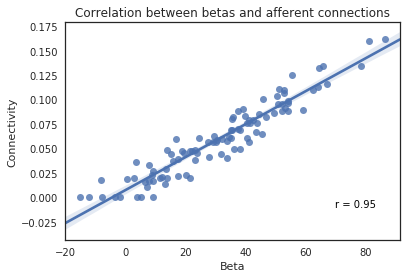

In [28]:
d = {'Beta': task_betas_postfmri[8:], 'Connectivity': afferent_cons[8:]}
df = pd.DataFrame(data=d)
sns.set_style("white")
p = sns.regplot(x='Beta', y='Connectivity', data = df)
p.text(70, -0.01, "r = %s"%(str(round(np.corrcoef(task_betas_postfmri[8:], afferent_cons[8:])[1][0],3))), horizontalalignment='left', color='black')
p.set_title('Correlation between betas and afferent connections')

## Experiment 2: How to subtract rest activity from task activity

Correct task activity by subtracting task activity generated using t-1 rest activity in Eq 3 from task activity generated using Eq as is and then run GLM on the "corrected activity"


In [29]:
taskdata_corrected = {}
task = 1

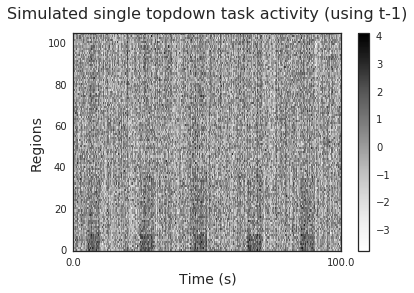

In [30]:
taskdata_corrected[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1, correction_step=1)

plt.figure()
plt.imshow(taskdata_corrected[task], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity (using t-1)', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

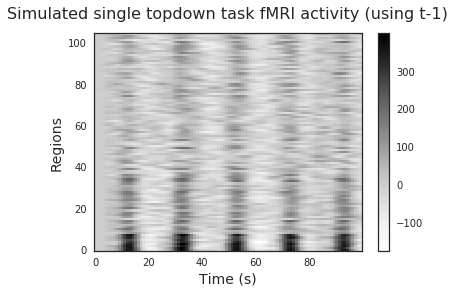

In [31]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
task_bold_corrected = model.convolveTimeseries(taskdata_corrected[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)
plt.figure()
plt.imshow(task_bold_corrected, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity (using t-1)', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

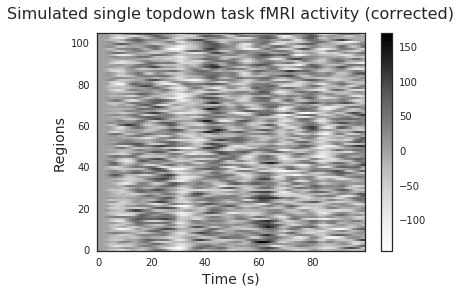

In [32]:
#Subtract activitiy generated using previous timestep from activity generated using current timestep

task_bold_corrected = task_bold - task_bold_corrected
plt.figure()
plt.imshow(task_bold_corrected, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity (corrected)', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### GLM on corrected activiy

In [33]:
task_betas_postfmri_corrected, task_resids_postfmri_corrected, task_tvals_postfmri_corrected, task_betas_ci_postfmri_corrected = model.runTaskGLM(task_bold_corrected, timing_convolved_downsampled)

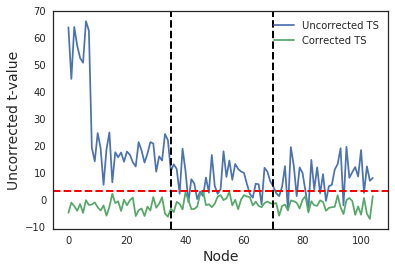

In [34]:
plt.plot(task_tvals_postfmri, label = "Uncorrected TS")
plt.plot(task_tvals_postfmri_corrected, label = "Corrected TS")
plt.ylabel('Uncorrected t-value',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=3,linewidth=2, color='red', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc='upper right')

## Questions

- Should we correct just for one timestep back or an (exponential) weighted average of all previous timesteps?

- Is the reduction in betas a real result or a mathematical certainty?  

- This might be a better/correct way to analyze task fmri but how would help our understanding of decision making in the brain?